In [1]:
## IMPORT RELEVANT LIBRAIES

# DATA WRANGLING AND ANALYSIS
import pandas   as pd
import datetime as dt
import numpy    as np
from   skimpy   import skim
from   random   import choice 
#import missingno

# DATA VISULIZATION 
import seaborn           as sns
import matplotlib.pyplot as plt

# DATE MANIPULATION
#from dateutil.relativedelta import relativedelta

In [2]:
#Import relevant datasets 

# CUSTOMER DEMOGRAPHIC DATASET
cusDemo    = pd.read_excel('KPMG_VI_New_raw_data_update_final.xlsx',sheet_name = 3 , parse_dates=True)
#Transation DATA
transc     = pd.read_excel('KPMG_VI_New_raw_data_update_final.xlsx', sheet_name = 1, parse_dates=True) 
#CUSTOMER ADDRESS
cusAddress = pd.read_excel('KPMG_VI_New_raw_data_update_final.xlsx', sheet_name = 4, parse_dates=True) 

C:\Users\Owner\AppData\Local\Temp\ipykernel_7384\3887902963.py:4: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  cusDemo    = pd.read_excel('KPMG_VI_New_raw_data_update_final.xlsx', sheet_name = 3 , parse_dates=True)


#### DATA CLEANING - CUSTOMER DEMOGRAPHICS

In [3]:
cusDemo_cleaned              = cusDemo.copy() 
cusDemo_cleaned.drop(columns = ['first_name', 'last_name', 'default'], inplace = True)

#Clean up gender column
cusDemo_cleaned.gender = cusDemo_cleaned['gender'].replace({ 'Male': 'M',
                                                'Female': 'F',
                                                'Femal': 'F'})

y  = 2017    
cusDemo_cleaned.DOB.fillna(cusDemo_cleaned.DOB.mode()[0], inplace = True)
cusDemo_cleaned.DOB = round(y - cusDemo_cleaned.DOB.dt.year).astype(int)
cusDemo_cleaned     = cusDemo_cleaned[cusDemo_cleaned.DOB < 100]

#GROUP AGE(Countinous) into discrete variables 
bins    = np.arange(7.5,97.5,5)
labels_ = np.arange(10,95,5)
cusDemo_cleaned['AgeClass'] = pd.cut(cusDemo_cleaned.DOB, bins, labels = labels_)
#cusDemo_cleaned[['AgeClass', 'DOB']]

# Function to fill missing values with random integers between 1 and 22
def fill_missing_with_random_row(row):
    return row.apply(lambda x: np.random.randint(1, 22) if pd.isnull(x) else x)

# Apply the function to the specified row
cusDemo_cleaned.tenure = fill_missing_with_random_row(cusDemo_cleaned.tenure)


"""Convert thsis statement direclty to a pandas dataframe instead of converting to csv first"""
#cusDemo_cleaned[["wealth_segment","job_title","job_industry_category"]].groupby(["wealth_segment","job_industry_category"]).value_counts().to_csv("check_dist.csv")
dictw = pd.read_csv("check_dist.csv")

dictw[(dictw.wealth_segment == "Affluent Customer") 
      & (dictw.job_title == "Editor")].job_industry_category.to_list()

# Function to fill missing values in column C
jic_all = list(dictw.job_industry_category.unique())
cusDemo_cleaned 

def fill_missing_values(cusDemo_cleaned):
    for index, row in cusDemo_cleaned.iterrows():
        if pd.isnull(row['job_industry_category']):
            jic = dictw[(dictw.wealth_segment == row['wealth_segment']) & (dictw.job_title == row['job_title'])].job_industry_category.to_list()
            if len(jic) < 1:
                 cusDemo_cleaned.at[index, 'job_industry_category'] = choice(jic_all)
            else :
                cusDemo_cleaned.at[index, 'job_industry_category'] = choice(jic)
    return cusDemo_cleaned

# Apply the function to the DataFrame
cusDemo_cleaned = fill_missing_values(cusDemo_cleaned)

#Yet to be tested
cusDemo_cleaned.job_title.fillna("Unspecified", inplace = True)

In [ ]:
cusDemo_cleaned = cusDemo.copy() 

##### DROP IRRELEVANT COLUMNS
'''
Drop  default column, i doesnt have a meaning
Drop  default first and last names, Name will not influence purchase pattern
'''
cusDemo_cleaned.drop(columns = ['first_name', 'last_name', 'default'], inplace = True)
#### CLEAN DATE OF BIRTH COLUMN
""" 
- Convert Date of birth to Age 
- Drop null values
- Find and drop outliers
"""

# CONVERT DATE OF BIRTH TO AGE AND CLASSIFY IN TENS 
#take the maximum transcatodedate as the time of the project 
y  = 2017    
"""Fill missing age with mode"""
cusDemo_cleaned.DOB.fillna(cusDemo_cleaned.DOB.mode()[0], inplace = True)
cusDemo_cleaned.DOB = round(y - cusDemo_cleaned.DOB.dt.year).astype(int)
#It seen there is an outlier Age, Lets find out if there are more than one customer that is more than  100 years old 

"""
Oops!, her just caught an oulier.
In a real life situation, we can verify the customer age bu in this case, i will drop the customer from our database 
and the null date of births
"""
cusDemo_cleaned = cusDemo_cleaned[cusDemo_cleaned.DOB < 100]
"""Classify age into bins"""

# Clean job_title','job_industry_category Columns
""""
- Find cell is missing values
- Drop nulls in both category ---> 'job_title','job_industry_category'
"""

cusDemo_cleaned.job_industry_category.isna().value_counts()
cusDemo_cleaned.dropna(how = 'any')

# Attain unique job title to job industry 
job_to_title = cusDemo_cleaned[['job_title','job_industry_category']].dropna().drop_duplicates().reset_index(drop = True)

job_to_title[job_to_title.job_title == 'Blank']
              
test = cusDemo[['customer_id','DOB']].dropna()
test['AGE'] = 2017 - test.DOB.dt.year
test.AGE.astype(int)

test = test[test != test.AGE.max()]

bins = np.arange(10,100,10)
labels_ = np.arange(10,90,10)
test['Grouping'] = pd.cut(test.AGE, bins, labels = labels_ )
test


#### DATA CLEANING - address data 

In [4]:
cusDemo_cleaned
cusAddress_cleaned = cusAddress.drop(["country"],axis =1) 

cusAddress_cleaned.state = cusAddress_cleaned['state'].replace({ 'New South Wales': 'NSW',
                                                'Victoria': 'VIC'})

#### DATA MERGING  - address and demographics data 

In [5]:
customer_data = cusDemo_cleaned.merge(cusAddress_cleaned, how = "inner", on = "customer_id")

#### DATA CLEANING - transcation data 

In [5]:
# Copy the transaaction data 
trans_cleaned = transc.copy()

# Investigate if there multiple transactions recorded 
trans_cleaned.transaction_id.duplicated().value_counts()
"""No duplicate transaction Id"""

# Convert product_first_sold_date to the right format 
trans_cleaned['product_first_sold_date'] = pd.to_datetime(trans_cleaned['product_first_sold_date'],
                                           unit = 'D',
                                           origin ='1899-12-30' )

#Convert online type to Boolean
def changeBoolean(var):
    if   var == 0.0:
        return False
    elif var == 1.0:
        return True
    else           :
        return True 
    
trans_cleaned['online_order'] = trans_cleaned['online_order'].apply(changeBoolean)

#Drop missing colums(validation)
trans_cleaned.dropna(inplace= True)
# Use only approved transcations 
trans_cleaned = trans_cleaned[trans_cleaned.order_status == 'Approved']

# ADD a profit column and profit ratio
trans_cleaned['profit']      = trans_cleaned['list_price'] - trans_cleaned['standard_cost']
trans_cleaned['profitRatio'] = trans_cleaned['list_price'] / trans_cleaned['standard_cost']

In [ ]:
# drop columns with null profit 
trans_cleaned          = trans_cleaned[trans_cleaned['profit'].notna()]

## ADD AN UNSPECIFIED COLUMN TO online_order that is na
trans_cleaned.online_order.fillna('Unspecified', inplace=True)

# Find all categorical columns 
columns = [i for i in list(trans_cleaned.columns) if trans_cleaned[i].dtype == 'O']

for item in columns:
    print(f'{item} unique Values {trans_cleaned[item].unique()}')
    
# Observe thatcertain transactions were cancelled and note that Cancelled transactions dont add up to the revenue
trans_cleaned.order_status.value_counts() 

#### THE  RELEVANT METRICS I USE WILL BE 
- TOTAL AND AVERAGE REVENUE PER CUSTOMER 
- FREQUENCY OF TRANSCATION 
- AVERAGE PROFIT RATIO  PER TRANSACTION 

In [6]:
transcMetrics = trans_cleaned.groupby('customer_id').agg({'profit' : ['sum', 'mean'],
                                          "customer_id" : 'count' ,
                                          'profitRatio' : ['sum', 'mean']})

In [26]:
trans_cleaned.to_csv("transaction.csv", index = False)
cusDemo_cleaned.to_csv("demographics.csv", index = False)
cusAddress_cleaned.to_csv("address.csv", index = False)

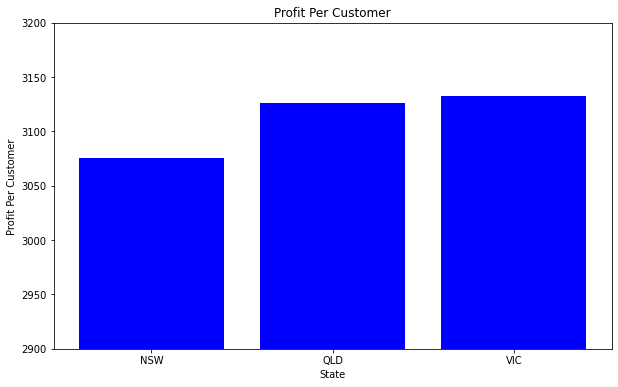

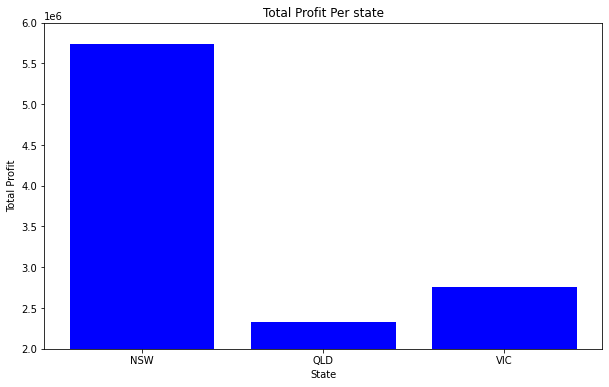

In [58]:
#What State has the most population and profit margin 
a = trans_cleaned.merge(cusAddress_cleaned, how = "inner", on = "customer_id")
a1 = a.groupby('state').agg({'profit' : ['sum'] , "customer_id" : 'nunique'})

a1.columns = ['total_profit', 'unique_customers']
a1['profit_per_customer'] = a1['total_profit'] / a1['unique_customers']
# Plotting the bar chart using seaborn
plt.figure(figsize=(10, 6))
plt.bar(a1.index, a1['profit_per_customer'], color='blue')
plt.title('Profit Per Customer')
plt.xlabel('State')
plt.ylabel('Profit Per Customer')
plt.ylim(2900, 3200)
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(a1.index, a1['total_profit'], color='blue')
plt.title('Total Profit Per state')
plt.xlabel('State')
plt.ylabel('Total Profit')
plt.ylim(2000000, 6000000)
plt.show()

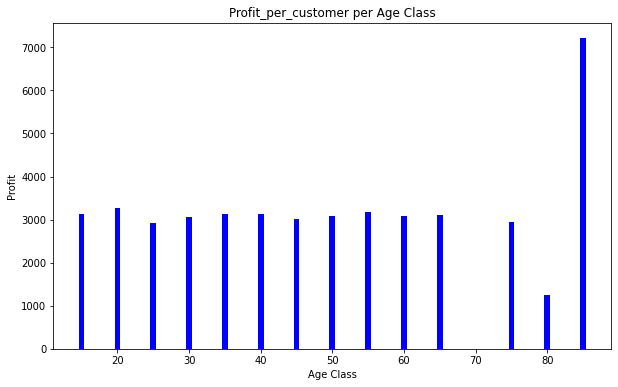

In [65]:
a = trans_cleaned.merge(cusDemo_cleaned, how = "inner", on = "customer_id")
a1 = a.groupby('AgeClass').agg({'profit' : ['sum'] , "customer_id" : 'nunique'})

a1.columns = ['total_profit', 'unique_customers']
a1['profit_per_customer'] = a1['total_profit'] / a1['unique_customers']
# Plotting the bar chart using seaborn
plt.figure(figsize=(10, 6))
plt.bar(a1.index, a1['profit_per_customer'], color='blue')
plt.title('Profit_per_customer per Age Class')
plt.xlabel('Age Class')
plt.ylabel('Profit')
#plt.ylim(2900, 3200)
plt.show()

TypeError: 'value' must be an instance of str or bytes, not a tuple

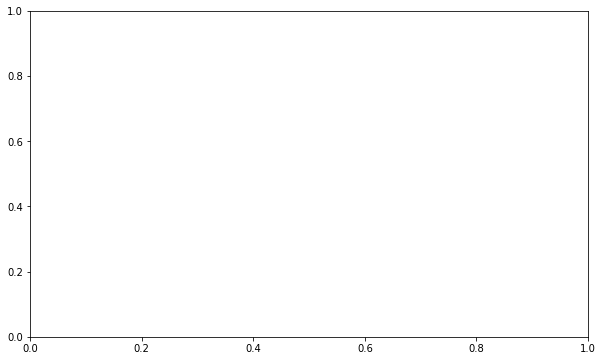

In [12]:
a = cusAddress_cleaned.merge(
    cusDemo_cleaned, how = "inner", on = "customer_id").merge(
        trans_cleaned, how = "inner", on = "customer_id")
a1 = a.groupby(['state','wealth_segment']).agg({'profit' : ['sum'] , "customer_id" : 'nunique'})
a1.columns = ['total_profit', 'unique_customers']
a1['profit_per_customer'] = a1['total_profit'] / a1['unique_customers']

plt.figure(figsize=(10,6))
plt.bar(a1.index, a1['profit_per_customer'], color='blue')
plt.title('Profit_per_customer per Age Class')
plt.xlabel('Age Class')
plt.ylabel('Profit')
#plt.ylim(2900, 3200)
plt.show()

#trans_cleaned
#cusDemo_cleaned
#cusAddress_cleaned

<AxesSubplot:xlabel='state,wealth_segment'>

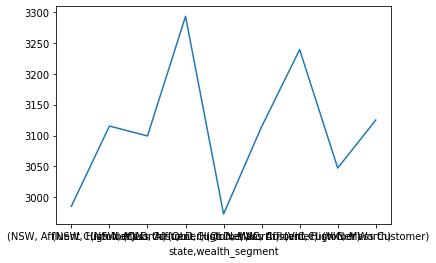

In [22]:
a1['profit_per_customer'].plot()

#### COMPUTATION
- COMPUTE AGE AND CLASSIFY BY AGE BRACKET

- AN APPROPRIATE METHOD IS USED TO CLASSIFY CURRENT TARGET- 1,0 WHICH WILL CORRESEPOND TO TRUE OR FALSE
  PROBLEM?? -- EHAT METHOD CAN I USE TO DESIGN A MODEL THAT CAN EFFECTIVELY CATEGORISE TH

#### VISUALIZATION AND CLASSIFICATION OF PUCAHSE BEHAVIOURS 
EDA IS CARRIED OUT O THE EXISTING DATASET AND MORE UNDERSTANDING OF THE PURCHASE BEHAVIOURS IS ATTAINED 

#### FEATURE ENGINEERING 
THE DATA SET IS ACCUSTOMED TO BE FIT INTO A MODEL

#### DEVELOP MODEL 
IN THIS CASE, WE WILL USE A CLASSICAL CLASSIFICTION MODEL TO CLASSIFY CUSKTOMERS INTO TWO GROUPS BASED ON THEIR PURCHASE BEHAVIOUS 

#### MODEL TESTING AND VALIDATION 
THE MODEL IS TESTED WITH THE TEST DATA TO VALIDATE THE CORRECTIES NESSA ND ACCUERACY

#### MODEL DEPLOYMENT
APPLY MODEL ON THE NEW CUSTOMERS FOR CLASSIFICATION